In [779]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [780]:
#import training set and test set
TrainingSetdf = pd.read_csv("BATADAL_dataset03.csv", parse_dates=True, index_col='DATETIME', dayfirst=True)
EvalSetdf=pd.read_csv("BATADAL_dataset04.csv", parse_dates=True, index_col='DATETIME', dayfirst=True)

In [781]:
#set the sensor that will be examined
sensor='L_T1'

In [782]:
#convert dataframe column to pandas series
signal=TrainingSetdf[sensor]
series=pd.Series(signal)


In [783]:
##AdFuller test to check whether our seiries is stationary or not. p value lower than 0.05 indicates stationarity####
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if(result[1]<0.05):
    d=0
else:
    d=1


ADF Statistic: -20.615633
p-value: 0.000000


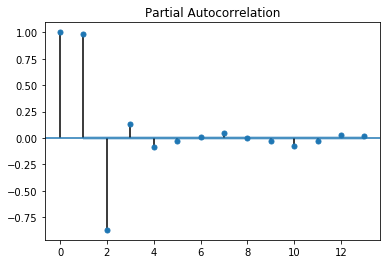

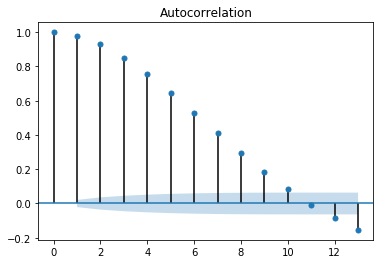

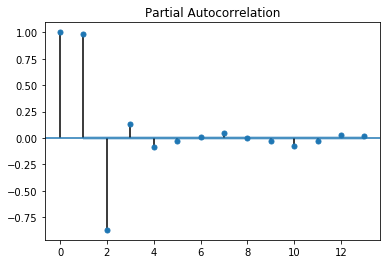

In [784]:
#autocorrelation_plot(series[0:20]) and partial autocorrelation plot to indicate the order p and q of ARMA model
plot_acf(series,lags=13)
plot_pacf(series,lags=13)

In [785]:
###AIC to find optimal parameters and further optimize order of ARMA model
bestAIC = np.inf 
finalOrder = None
bestModel = None

pRange = range(1,4) 
qRange = range(1,3) 
dRange=range(0,1)
for i in pRange:
    for j in qRange:
        
            try:
                modeltmp = smt.ARIMA(TrainingSetdf[sensor], order=(i,d,j)).fit(method='mle', trend='nc')
                tempAIC = modeltmp.aic
                if tempAIC < bestAIC:
                    bestAIC = tempAIC
                    finalOrder = (i, d, j)
                    bestModel = modeltmp
            except: continue


print('aic: {:6.5f} | order: {}'.format(bestAIC, finalOrder))

print(bestModel.summary())

C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No fre

aic: -12999.57216 | order: (3, 0, 1)
                              ARMA Model Results                              
Dep. Variable:                   L_T1   No. Observations:                 8761
Model:                     ARMA(3, 1)   Log Likelihood                6504.786
Method:                           mle   S.D. of innovations              0.115
Date:                Mon, 04 Jun 2018   AIC                         -12999.572
Time:                        22:43:39   BIC                         -12964.182
Sample:                    01-06-2014   HQIC                        -12987.514
                         - 01-06-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.L_T1     2.8510        nan        nan        nan         nan         nan
ar.L2.L_T1    -2.7371        nan        nan        nan         nan         nan
ar.L3.L_T1     

C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\statsmodels\tsa\arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [768]:
#rename sensor to fit in the test data_set
sensor2=' '+sensor


In [769]:
#we create predictions on the test data using the optimal ARMA model order we calculated earlier
testModel =smt.ARIMA( EvalSetdf[sensor2], order=finalOrder).fit(method='mle', trend='nc')

C:\Users\pc1\Anaconda3\envs\exercises_stanford\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [770]:
#find the residuals of this model
#testResid=testModel.resid[8763:]
testResid=testModel.resid[2:]

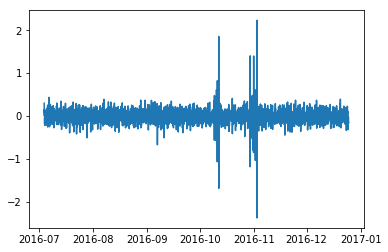

In [771]:
#plot the residuals over time.Anomalies can clearly be noticed
plt.plot(testResid)


(-2.3791181393907896, 2.233301047097251)

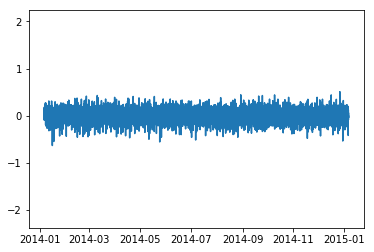

In [772]:
#plot residuals of the training set to show the comparison.No attacks exist and thus no clear anomalies are detected here.
trainresid=bestModel.resid[2:]
plt.plot(trainresid)
plt.ylim(ymin=min(testResid),ymax=max(testResid))

In [773]:
#set threshold sensibly.Start with 2* std of the residual, and gradually increase in order to minimize anomalies on non-attacked dataset
testStd = np.std(testResid)
initialThreshold=2*testStd
maxThreshold=3.5*testStd
threshold=initialThreshold
while len(trainresid[trainresid > threshold])>0 and threshold<maxThreshold:
    threshold=threshold*1.05
print(threshold)

0.533326899274043


In [774]:
det_anom_lit = testResid[testResid > threshold]


In [775]:
anomTrain=trainresid[trainresid > threshold]


In [776]:
datesOfDetection=[]
for i in range(len(det_anom_lit)):
    date=det_anom_lit.index[i].strftime("%Y-%m-%d %H:%M:%S")
    datesOfDetection.append(date)
print(datesOfDetection)

['2016-10-10 13:00:00', '2016-10-11 01:00:00', '2016-10-11 20:00:00', '2016-10-29 19:00:00', '2016-10-31 19:00:00', '2016-11-01 14:00:00', '2016-11-02 17:00:00']


In [777]:
tp=0
fp=0

In [778]:
for date in datesOfDetection:
    if(EvalSetdf.loc[date][43]==1):
       tp+=1
    else:
       fp+=1
print(tp)
print(fp)

4
3
